In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar.vecm as vm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100


def calculateMaxDD(cumret):
    """최대 낙폭 계산"""
    highwatermark = np.zeros(cumret.shape)
    drawdown = np.zeros(cumret.shape)
    drawdownduration = np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t] = np.maximum(highwatermark[t-1], cumret.iloc[t] if hasattr(cumret, 'iloc') else cumret[t])
        val = cumret.iloc[t] if hasattr(cumret, 'iloc') else cumret[t]
        drawdown[t] = (1 + val) / (1 + highwatermark[t]) - 1
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    maxDD = np.min(drawdown)
    maxDDD = np.max(drawdownduration)
    return maxDD, maxDDD

# Chapter 4: 주식과 ETF의 평균 회귀 (Mean Reversion of Stocks and ETFs)

## 목차

1. [개요 및 문제 정의](#1.-개요-및-문제-정의)
2. [사용 데이터](#2.-사용-데이터)
3. [분석 1: Buy-on-Gap 모델](#3.-분석-1:-Buy-on-Gap-모델)
4. [분석 2: SPY 인덱스 차익거래](#4.-분석-2:-SPY-인덱스-차익거래)
5. [분석 3: 횡단면 선형 롱-숏 모델](#5.-분석-3:-횡단면-선형-롱-숏-모델)
6. [분석 4: 실적 발표 후 표류 (PEAD)](#6.-분석-4:-PEAD)
7. [전략 종합 비교](#7.-전략-종합-비교)
8. [결론 및 권고사항](#8.-결론-및-권고사항)

---

## 1. 개요 및 문제 정의

Chapter 4는 주식과 ETF 시장에서의 평균 회귀 전략을 다룬다. 핵심 질문:
- 개별 주식의 페어 트레이딩은 왜 어려운가?
- ETF와 구성 주식 간 차익거래는 어떻게 구현하는가?
- 횡단면(cross-sectional) 평균 회귀 전략의 원리와 성과는?

### 핵심 수학적 개념

**횡단면 선형 롱-숏 가중치 (식 4.1):**

$$w_i = -\frac{r_i - \langle r_j \rangle}{\sum_k |r_k - \langle r_j \rangle|}$$

여기서 $r_i$는 $i$번째 주식의 일일 수익률, $\langle r_j \rangle$는 유니버스 내 모든 주식의 평균 일일 수익률이다.
분모의 정규화 계수로 인해 매일 동일한 총 자본(\$1)을 투자한다.

**시계열 vs 횡단면 평균 회귀의 차이:**
- **시계열 평균 회귀**: 가격이 자기 과거 평균으로 회귀
- **횡단면 평균 회귀**: 상대 수익률의 직렬 역상관에 의존. 유니버스 대비 상대적 성과가 반전

---

## 2. 사용 데이터

| 파일명 | 내용 | 컬럼 수 | 기간 | 용도 |
|--------|------|---------|------|------|
| `inputDataOHLCDaily_20120424_cl.csv` | S&P 500 일일 종가 | 498 | 2006-05~2012-04 | 모든 전략 |
| `inputDataOHLCDaily_20120424_op.csv` | S&P 500 일일 시가 | 498 | 2006-05~2012-04 | BoG, 일중 전략 |
| `inputDataOHLCDaily_20120424_hi.csv` | S&P 500 일일 고가 | 498 | 2006-05~2012-04 | BoG |
| `inputDataOHLCDaily_20120424_lo.csv` | S&P 500 일일 저가 | 498 | 2006-05~2012-04 | BoG |
| `inputDataOHLCDaily_20120424_stocks.csv` | 주식 티커명 | 497 | - | 컬럼명 매핑 |
| `inputData_ETF_cl.csv` | 67개 ETF 일일 종가 | 68 | 2006-04~2012-04 | 인덱스 차익거래 |
| `inputData_ETF_stocks.csv` | ETF 티커명 | 67 | - | 컬럼명 매핑 |
| `earnannFile.csv` | 어닝 발표 플래그 | 498 | 2011~ | PEAD 전략 |

**데이터 특성**: S&P 500 구성 주식 약 497개의 일일 OHLC 데이터. 생존자 편향(survivorship bias)이 있음에 유의.

In [2]:
# === 데이터 로드 ===

# 주식 티커명
stocks_df = pd.read_csv('inputDataOHLCDaily_20120424_stocks.csv')
stock_names = stocks_df.iloc[0].values.tolist()
print(f'주식 티커: {len(stock_names)}개')

# OHLC 데이터 로드 함수
def load_price_file(filename):
    df = pd.read_csv(filename)
    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d')
    df.set_index(date_col, inplace=True)
    df.index.name = 'Date'
    df.columns = stock_names
    return df

cl = load_price_file('inputDataOHLCDaily_20120424_cl.csv')
op = load_price_file('inputDataOHLCDaily_20120424_op.csv')
hi = load_price_file('inputDataOHLCDaily_20120424_hi.csv')
lo = load_price_file('inputDataOHLCDaily_20120424_lo.csv')
print(f'OHLC: {len(cl)} 거래일 x {len(cl.columns)} 주식, 기간: {cl.index[0].date()} ~ {cl.index[-1].date()}')

# ETF 데이터
etf_stocks_df = pd.read_csv('inputData_ETF_stocks.csv')
etf_names = etf_stocks_df.iloc[0].values.tolist()
etf_df = pd.read_csv('inputData_ETF_cl.csv')
date_col = etf_df.columns[0]
etf_df[date_col] = pd.to_datetime(etf_df[date_col], format='%Y%m%d')
etf_df.set_index(date_col, inplace=True)
etf_df.index.name = 'Date'
etf_df.columns = etf_names
print(f'ETF: {len(etf_df)} 거래일 x {len(etf_df.columns)} ETF')

# 어닝 발표 데이터
earnann = pd.read_csv('earnannFile.csv')
date_col = earnann.columns[0]
earnann[date_col] = pd.to_datetime(earnann[date_col], format='%Y%m%d')
earnann.set_index(date_col, inplace=True)
earnann.index.name = 'Date'
print(f'어닝 발표: {len(earnann)} 거래일')

주식 티커: 497개
OHLC: 1500 거래일 x 497 주식, 기간: 2006-05-11 ~ 2012-04-24
ETF: 1500 거래일 x 67 ETF
어닝 발표: 330 거래일


---

## 3. 분석 1: Buy-on-Gap 모델 (예제 4.1)

### 전략 원리

주가 지수 선물이 개장 전 하락하는 날, 특정 주식이 패닉 셀링으로 과도하게 하락한다.
이 패닉이 끝나면 주식은 하루 동안 점차 상승하는 일중 평균 회귀 현상을 이용한다.

**전략 규칙:**
1. 전일 저가에서 1 표준편차(90일) 이상 갭다운한 주식을 선택
2. 시가가 20일 이동평균보다 높은 주식만 필터링 (모멘텀 필터)
3. 갭이 가장 큰 10개 주식 매수
4. 장 마감 시 청산

**모멘텀 필터의 중요성**: 시가 > 20일 MA 조건은 장기 하락 추세에 있는 주식(부정적 뉴스)을
걸러내고, 일시적 유동성 수요로 인한 하락만 포착한다.

책 결과: APR=8.7%, Sharpe=1.5

In [3]:
# === 분석 1: Buy-on-Gap 모델 ===

topN = 10
entryZscore = 1
lookback_bog = 20

# 종가 대 종가 수익률의 90일 롤링 표준편차 (전일 기준)
retC2C = cl.pct_change()
stdretC2C90d = retC2C.rolling(90).std().shift(1)

# 매수 가격: 전일 저가 * (1 - entryZscore * std)
buyPrice = lo.shift(1) * (1 - entryZscore * stdretC2C90d)

# 갭 수익률: (시가 - 전일 저가) / 전일 저가
retGap = (op - lo.shift(1)) / lo.shift(1)

# 20일 이동평균 (전일 기준)
ma_bog = cl.rolling(lookback_bog).mean().shift(1)

pnl_list = []
trade_counts = []

for t in range(1, len(cl)):
    hasData = (retGap.iloc[t].notna() &
              (op.iloc[t] < buyPrice.iloc[t]) &
              (op.iloc[t] > ma_bog.iloc[t]))
    valid_stocks = retGap.iloc[t][hasData].dropna()

    if len(valid_stocks) > 0:
        sorted_stocks = valid_stocks.sort_values(ascending=True)
        selected = sorted_stocks.head(min(topN, len(sorted_stocks)))
        retO2C = (cl.iloc[t] - op.iloc[t]) / op.iloc[t]
        daily_pnl = retO2C[selected.index].sum()
        pnl_list.append(daily_pnl / topN)
        trade_counts.append(len(selected))
    else:
        pnl_list.append(0.0)
        trade_counts.append(0)

ret_bog = pd.Series(pnl_list, index=cl.index[1:]).fillna(0)
cumret_bog = (1 + ret_bog).cumprod() - 1

apr_bog = (1 + ret_bog).prod() ** (252 / len(ret_bog)) - 1
sharpe_bog = np.sqrt(252) * ret_bog.mean() / ret_bog.std()
maxDD_bog, maxDDD_bog = calculateMaxDD(cumret_bog)

avg_trades = np.mean([c for c in trade_counts if c > 0]) if any(c > 0 for c in trade_counts) else 0
active_days = sum(1 for c in trade_counts if c > 0)

print(f'Buy-on-Gap 모델 (예제 4.1)')
print(f'  APR      = {apr_bog*100:.2f}%')
print(f'  Sharpe   = {sharpe_bog:.4f}')
print(f'  Max DD   = {maxDD_bog*100:.2f}%')
print(f'  Max DDD  = {maxDDD_bog:.0f}일')
print(f'  활성 거래일 = {active_days}/{len(ret_bog)}, 평균 종목수 = {avg_trades:.1f}')
print(f'  (책 기대값: APR=8.7%, Sharpe=1.5)')

Buy-on-Gap 모델 (예제 4.1)
  APR      = 8.28%
  Sharpe   = 1.6389
  Max DD   = -5.25%
  Max DDD  = 159일
  활성 거래일 = 389/1499, 평균 종목수 = 1.8
  (책 기대값: APR=8.7%, Sharpe=1.5)


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 8.28% | 8.7% |
| Sharpe Ratio | 1.6389 | 1.5 |
| Max Drawdown | -5.25% | - |
| Max DD Duration | 159일 | - |
| 활성 거래일 | 389/1499 | - |
| 평균 종목수/일 | 1.8 | - |

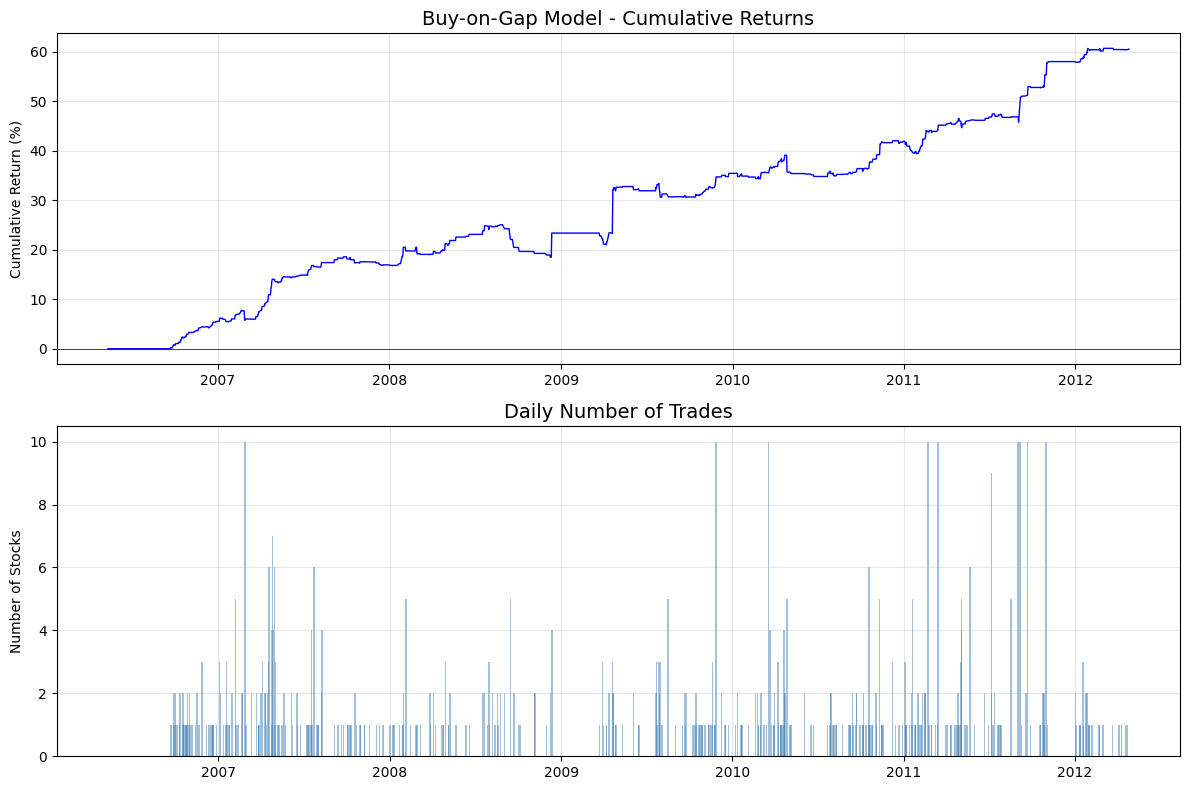

In [4]:
# === Buy-on-Gap 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_bog.index, cumret_bog.values * 100, 'b-', linewidth=1)
axes[0].set_title('Buy-on-Gap Model - Cumulative Returns', fontsize=14)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linewidth=0.5)

trade_series = pd.Series(trade_counts, index=cl.index[1:])
axes[1].bar(trade_series.index, trade_series.values, color='steelblue', alpha=0.5, width=3)
axes[1].set_title('Daily Number of Trades', fontsize=14)
axes[1].set_ylabel('Number of Stocks')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 4. 분석 2: SPY 인덱스 차익거래 (예제 4.2)

### 방법론

1. **훈련 단계** (2007): 각 SPX 주식과 SPY에 대해 요한센 공적분 검정 수행
2. 공적분하는 주식으로 동일 자본 배분 롱온리 포트폴리오 구성
3. 포트폴리오와 SPY의 공적분 재확인
4. **테스트 단계** (2008~): 5일 룩백의 선형 평균 회귀 전략 적용

**공적분 검정 수식** (요한센 검정):

$$\Delta Y_t = \Pi Y_{t-1} + \epsilon_t$$

여기서 $\Pi = \alpha \beta'$, $\beta$는 공적분 벡터(고유벡터), $\alpha$는 조정 속도

책 결과: APR=4.5%, Sharpe=1.3

In [5]:
# === 분석 2: SPY 인덱스 차익거래 ===

spy = etf_df[['SPY']].copy()
common_dates = cl.index.intersection(spy.index)
cl_common = cl.loc[common_dates].copy()
spy_common = spy.loc[common_dates].copy()

# 훈련/테스트 기간
train_mask = (common_dates >= '2007-01-01') & (common_dates <= '2007-12-31')
test_mask = common_dates > '2007-12-31'
train_dates = common_dates[train_mask]
test_dates = common_dates[test_mask]
print(f'훈련: {train_dates[0].date()} ~ {train_dates[-1].date()} ({len(train_dates)}일)')
print(f'테스트: {test_dates[0].date()} ~ {test_dates[-1].date()} ({len(test_dates)}일)')

# 각 주식과 SPY의 공적분 검정 (훈련 세트)
isCoint = {}
spy_train = spy_common.loc[train_dates, 'SPY'].values
tested = 0
coint_count = 0

for stock in cl_common.columns:
    stock_train = cl_common.loc[train_dates, stock].values
    y2 = np.column_stack([stock_train, spy_train])
    bad = np.any(np.isnan(y2), axis=1)
    y2_clean = y2[~bad]
    if y2_clean.shape[0] > 250:
        tested += 1
        try:
            result = vm.coint_johansen(y2_clean, det_order=0, k_ar_diff=1)
            if result.lr1[0] > result.cvt[0, 0]:
                isCoint[stock] = True
                coint_count += 1
        except Exception:
            pass

coint_stocks = list(isCoint.keys())
print(f'검정: {tested}개 중 {coint_count}개가 SPY와 공적분')

# 포트폴리오-SPY 공적분 확인
coint_prices_train = cl_common.loc[train_dates, coint_stocks]
logMktVal_train = np.log(coint_prices_train).sum(axis=1)
ytest = np.column_stack([logMktVal_train.values, np.log(spy_common.loc[train_dates, 'SPY'].values)])
bad = np.any(np.isnan(ytest), axis=1)
ytest_clean = ytest[~bad]

result_port = vm.coint_johansen(ytest_clean, det_order=0, k_ar_diff=1)
port_coint = result_port.lr1[0] > result_port.cvt[0, 1]
evec = result_port.evec[:, 0]
print(f'포트폴리오-SPY 공적분: {"Yes (95%)" if port_coint else "No"}')
print(f'고유벡터: [{evec[0]:.4f}, {evec[1]:.4f}]')

# 테스트 기간 선형 평균 회귀
coint_prices_test = cl_common.loc[test_dates, coint_stocks]
spy_test = spy_common.loc[test_dates, 'SPY']
yNplus = pd.concat([coint_prices_test, spy_test], axis=1)

weights_ia = pd.DataFrame(index=test_dates, columns=yNplus.columns)
for col_ia in coint_stocks:
    weights_ia[col_ia] = evec[0]
weights_ia['SPY'] = evec[1]
weights_ia = weights_ia.astype(float)

logMktVal = (weights_ia * np.log(yNplus)).sum(axis=1)
lookback_ia = 5
ma_ia = logMktVal.rolling(lookback_ia).mean()
mstd_ia = logMktVal.rolling(lookback_ia).std()
numUnits_ia = -(logMktVal - ma_ia) / mstd_ia
numUnits_ia = numUnits_ia.fillna(0)

positions_ia = weights_ia.multiply(numUnits_ia, axis=0)
log_prices_ia = np.log(yNplus)
log_ret_ia = log_prices_ia - log_prices_ia.shift(1)
pnl_ia = (positions_ia.shift(1) * log_ret_ia).sum(axis=1)
capital_ia = positions_ia.shift(1).abs().sum(axis=1).replace(0, np.nan)
ret_ia = (pnl_ia / capital_ia).fillna(0).iloc[lookback_ia:]
cumret_ia = (1 + ret_ia).cumprod() - 1

apr_ia = (1 + ret_ia).prod() ** (252 / len(ret_ia)) - 1
sharpe_ia = np.sqrt(252) * ret_ia.mean() / ret_ia.std()
maxDD_ia, maxDDD_ia = calculateMaxDD(cumret_ia)

print(f'APR      = {apr_ia*100:.2f}%')
print(f'Sharpe   = {sharpe_ia:.4f}')
print(f'Max DD   = {maxDD_ia*100:.2f}%')
print(f'Max DDD  = {maxDDD_ia:.0f}일')
print(f'(책 기대값: APR=4.5%, Sharpe=1.3)')

훈련: 2007-01-03 ~ 2007-12-31 (251일)
테스트: 2008-01-02 ~ 2012-04-09 (1076일)
검정: 480개 중 98개가 SPY와 공적분
포트폴리오-SPY 공적분: Yes (95%)
고유벡터: [1.0939, -105.5600]
APR      = 4.51%
Sharpe   = 1.3225
Max DD   = -3.04%
Max DDD  = 349일
(책 기대값: APR=4.5%, Sharpe=1.3)


### 결과

- SPY와 공적분하는 주식: **98** 개
- 고유벡터: [1.0939, -105.5600]

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 4.51% | 4.5% |
| Sharpe Ratio | 1.3225 | 1.3 |
| Max Drawdown | -3.04% | - |
| Max DD Duration | 349일 | - |

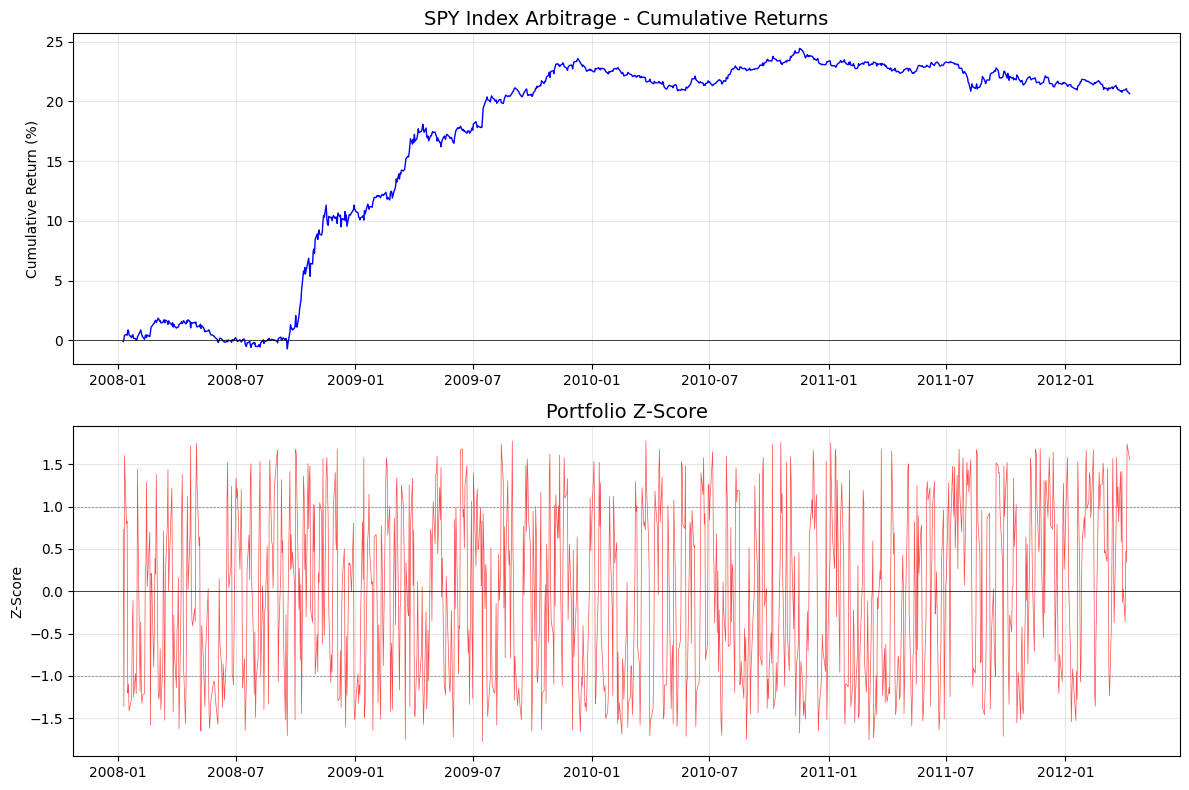

In [6]:
# === SPY 인덱스 차익거래 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_ia.index, cumret_ia.values * 100, 'b-', linewidth=1)
axes[0].set_title('SPY Index Arbitrage - Cumulative Returns', fontsize=14)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linewidth=0.5)

zScore_ia = numUnits_ia.iloc[lookback_ia:]
axes[1].plot(zScore_ia.index, zScore_ia.values, 'r-', linewidth=0.5, alpha=0.7)
axes[1].set_title('Portfolio Z-Score', fontsize=14)
axes[1].set_ylabel('Z-Score')
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].axhline(y=1, color='gray', linewidth=0.5, linestyle='--')
axes[1].axhline(y=-1, color='gray', linewidth=0.5, linestyle='--')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 분석 3: 횡단면 선형 롱-숏 모델 (예제 4.3, 4.4)

### 전략 원리

Khandani & Lo (2007)가 제안한 전략. 매일 각 주식의 수익률에서 시장 평균을 빼고,
이 상대 수익률을 역방향으로 투자한다.

$$w_i = -\frac{r_i - \langle r_j \rangle}{\sum_k |r_k - \langle r_j \rangle|}$$

**특징**: 완전히 선형, 매개변수 없음, 달러 중립. 2008년 리먼 위기에서도 양의 수익.

**두 가지 변형:**
- **Close-to-Close (예제 4.3)**: 전일 종가 -> 당일 종가 수익률로 가중치 결정
- **Intraday (예제 4.4)**: 전일 종가 -> 당일 시가 수익률로 가중치, 시가 -> 종가로 수익 실현

책 결과: C2C APR=13.7%, Sharpe=1.3 / Intraday APR=73%, Sharpe=4.7

In [7]:
# === 분석 3: 횡단면 선형 롱-숏 모델 ===

# 2007-01-02 ~ 2011-12-30 필터링
mask_cs = (cl.index >= '2007-01-03') & (cl.index <= '2011-12-30')
cl_cs = cl.loc[mask_cs].copy()
op_cs = op.loc[mask_cs].copy()

# === Close-to-Close 전략 (예제 4.3) ===
ret_cs = cl_cs.pct_change()
marketRet_cs = ret_cs.mean(axis=1)

weights_c2c = -(ret_cs.subtract(marketRet_cs, axis=0))
abs_sum_c2c = weights_c2c.abs().sum(axis=1).replace(0, np.nan)
weights_c2c = weights_c2c.div(abs_sum_c2c, axis=0).fillna(0)

dailyret_c2c = (weights_c2c.shift(1) * ret_cs).sum(axis=1).iloc[1:].fillna(0)
cumret_c2c = (1 + dailyret_c2c).cumprod() - 1
apr_c2c = (1 + dailyret_c2c).prod() ** (252 / len(dailyret_c2c)) - 1
sharpe_c2c = np.sqrt(252) * dailyret_c2c.mean() / dailyret_c2c.std()
maxDD_c2c, maxDDD_c2c = calculateMaxDD(cumret_c2c)

print(f'[Close-to-Close]')
print(f'  APR = {apr_c2c*100:.2f}%, Sharpe = {sharpe_c2c:.4f}, MaxDD = {maxDD_c2c*100:.2f}%')

# === Intraday 전략 (예제 4.4) ===
retC2O = (op_cs - cl_cs.shift(1)) / cl_cs.shift(1)
marketRetC2O = retC2O.mean(axis=1)

weights_intra = -(retC2O.subtract(marketRetC2O, axis=0))
abs_sum_intra = weights_intra.abs().sum(axis=1).replace(0, np.nan)
weights_intra = weights_intra.div(abs_sum_intra, axis=0).fillna(0)

retO2C = (cl_cs - op_cs) / op_cs
capital_intra = weights_intra.abs().sum(axis=1).replace(0, np.nan)
dailyret_intra = ((weights_intra * retO2C).sum(axis=1) / capital_intra).iloc[1:].fillna(0)
cumret_intra = (1 + dailyret_intra).cumprod() - 1
apr_intra = (1 + dailyret_intra).prod() ** (252 / len(dailyret_intra)) - 1
sharpe_intra = np.sqrt(252) * dailyret_intra.mean() / dailyret_intra.std()
maxDD_intra, maxDDD_intra = calculateMaxDD(cumret_intra)

print(f'[Intraday]')
print(f'  APR = {apr_intra*100:.2f}%, Sharpe = {sharpe_intra:.4f}, MaxDD = {maxDD_intra*100:.2f}%')

# 연도별 성과
print(f'\n{"연도":<6} {"C2C APR":>10} {"C2C Sharpe":>12} {"Intra APR":>12} {"Intra Sharpe":>14}')
print('-' * 56)
for year in sorted(dailyret_c2c.index.year.unique()):
    yr_c = dailyret_c2c[dailyret_c2c.index.year == year]
    yr_apr_c = (1 + yr_c).prod() ** (252/len(yr_c)) - 1
    yr_sh_c = np.sqrt(252) * yr_c.mean() / yr_c.std() if yr_c.std() > 0 else 0
    yr_i = dailyret_intra[dailyret_intra.index.year == year]
    yr_apr_i = (1 + yr_i).prod() ** (252/len(yr_i)) - 1 if len(yr_i) > 0 else 0
    yr_sh_i = np.sqrt(252) * yr_i.mean() / yr_i.std() if len(yr_i) > 0 and yr_i.std() > 0 else 0
    print(f'{year:<6} {yr_apr_c*100:>9.2f}% {yr_sh_c:>11.2f} {yr_apr_i*100:>11.2f}% {yr_sh_i:>13.2f}')

[Close-to-Close]
  APR = 13.69%, Sharpe = 1.2600, MaxDD = -9.94%
[Intraday]
  APR = 73.23%, Sharpe = 4.7153, MaxDD = -6.13%

연도        C2C APR   C2C Sharpe    Intra APR   Intra Sharpe
--------------------------------------------------------
2007       -3.06%       -0.58       97.71%          8.83
2008       30.16%        1.77      161.09%          5.37
2009       33.45%        2.02       91.87%          4.66
2010        1.82%        0.38       36.84%          5.27
2011       10.58%        1.54       15.04%          2.01


### 전체 기간 성과 비교

| 지표 | Close-to-Close | Intraday | 책 기대값 (C2C) | 책 기대값 (Intra) |
|------|---------------|----------|---------------|------------------|
| APR | 13.69% | 73.23% | 13.7% | 73% |
| Sharpe | 1.2600 | 4.7153 | 1.3 | 4.7 |
| Max DD | -9.94% | -6.13% | - | - |
| Max DDD | 240일 | 43일 | - | - |

### 연도별 성과

| 연도 | C2C APR | C2C Sharpe | Intraday APR | Intraday Sharpe |
|------|---------|-----------|-------------|----------------|
| 2007 | -3.06% | -0.58 | 97.71% | 8.83 |
| 2008 | 30.16% | 1.77 | 161.09% | 5.37 |
| 2009 | 33.45% | 2.02 | 91.87% | 4.66 |
| 2010 | 1.82% | 0.38 | 36.84% | 5.27 |
| 2011 | 10.58% | 1.54 | 15.04% | 2.01 |

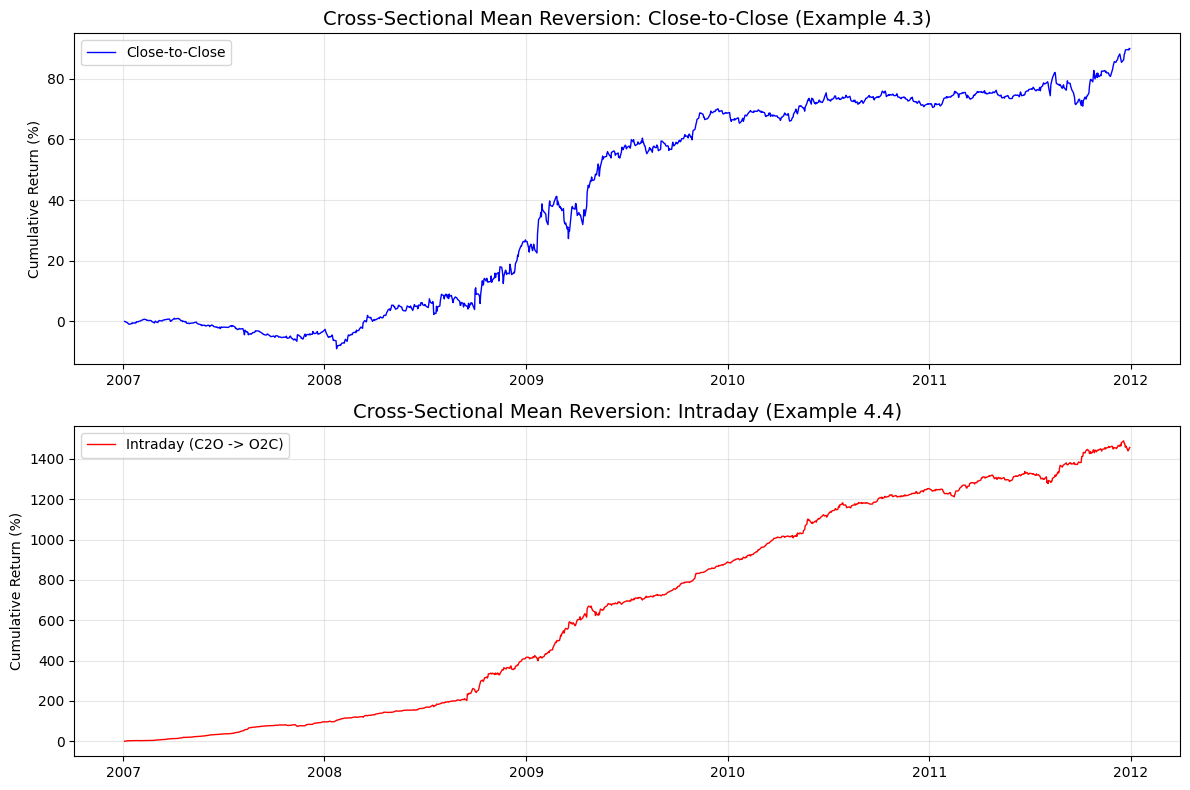

In [8]:
# === 횡단면 평균 회귀 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_c2c.index, cumret_c2c.values * 100, 'b-', linewidth=1, label='Close-to-Close')
axes[0].set_title('Cross-Sectional Mean Reversion: Close-to-Close (Example 4.3)', fontsize=14)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(cumret_intra.index, cumret_intra.values * 100, 'r-', linewidth=1, label='Intraday (C2O -> O2C)')
axes[1].set_title('Cross-Sectional Mean Reversion: Intraday (Example 4.4)', fontsize=14)
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

---

## 6. 분석 4: 실적 발표 후 표류 (PEAD)

### 전략 원리

어닝 발표일에 종가 -> 시가 갭이 90일 표준편차의 0.5배를 초과하면 롱,
-0.5배 미만이면 숏. 당일 종가에 청산하는 일중 전략.

책 결과: APR=6.8%, Sharpe=1.49, MaxDD=-2.6%

In [9]:
# === 분석 4: PEAD (Post-Earnings Announcement Drift) ===

common_dates_pead = cl.index.intersection(earnann.index)
common_stocks_pead = [s for s in cl.columns if s in earnann.columns]

cl_pead = cl.loc[common_dates_pead, common_stocks_pead]
op_pead = op.loc[common_dates_pead, common_stocks_pead]
earnann_pead = earnann.loc[common_dates_pead, common_stocks_pead]

print(f'PEAD 데이터: {len(common_dates_pead)} 거래일 x {len(common_stocks_pead)} 주식')

lookback_pead = 90
maxPositions = 30

# Close-to-Open 수익률
retC2O_pead = (op_pead - cl_pead.shift(1)) / cl_pead.shift(1)
stdC2O_pead = retC2O_pead.rolling(lookback_pead).std()

# 어닝 발표일에 갭이 큰 주식
longs_pead = (retC2O_pead >= 0.5 * stdC2O_pead) & (earnann_pead == 1)
shorts_pead = (retC2O_pead <= -0.5 * stdC2O_pead) & (earnann_pead == 1)

retO2C_pead = (cl_pead - op_pead) / op_pead

positions_pead = pd.DataFrame(0.0, index=cl_pead.index, columns=cl_pead.columns)
positions_pead[longs_pead] = 1
positions_pead[shorts_pead] = -1

pnl_pead = (positions_pead * retO2C_pead).sum(axis=1) / maxPositions
pnl_pead = pnl_pead.iloc[lookback_pead:]
cumret_pead = (1 + pnl_pead).cumprod() - 1

apr_pead = (1 + pnl_pead).prod() ** (252 / len(pnl_pead)) - 1
sharpe_pead = np.sqrt(252) * pnl_pead.mean() / pnl_pead.std()
maxDD_pead, maxDDD_pead = calculateMaxDD(cumret_pead)

daily_pos_pead = positions_pead.abs().sum(axis=1).iloc[lookback_pead:]
avg_pos_pead = daily_pos_pead[daily_pos_pead > 0].mean() if (daily_pos_pead > 0).any() else 0

print(f'APR      = {apr_pead*100:.2f}%')
print(f'Sharpe   = {sharpe_pead:.4f}')
print(f'Max DD   = {maxDD_pead*100:.2f}%')
print(f'Max DDD  = {maxDDD_pead:.0f}일')
print(f'평균 동시 포지션 = {avg_pos_pead:.1f}')
print(f'(책 기대값: APR=6.8%, Sharpe=1.49, MaxDD=-2.6%)')

PEAD 데이터: 330 거래일 x 497 주식
APR      = 9.49%
Sharpe   = 1.7520
Max DD   = -2.61%
Max DDD  = 109일
평균 동시 포지션 = 6.9
(책 기대값: APR=6.8%, Sharpe=1.49, MaxDD=-2.6%)


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 9.49% | 6.8% |
| Sharpe Ratio | 1.7520 | 1.49 |
| Max Drawdown | -2.61% | -2.6% |
| Max DD Duration | 109일 | 109 |
| 평균 동시 포지션 | 6.9 | - |

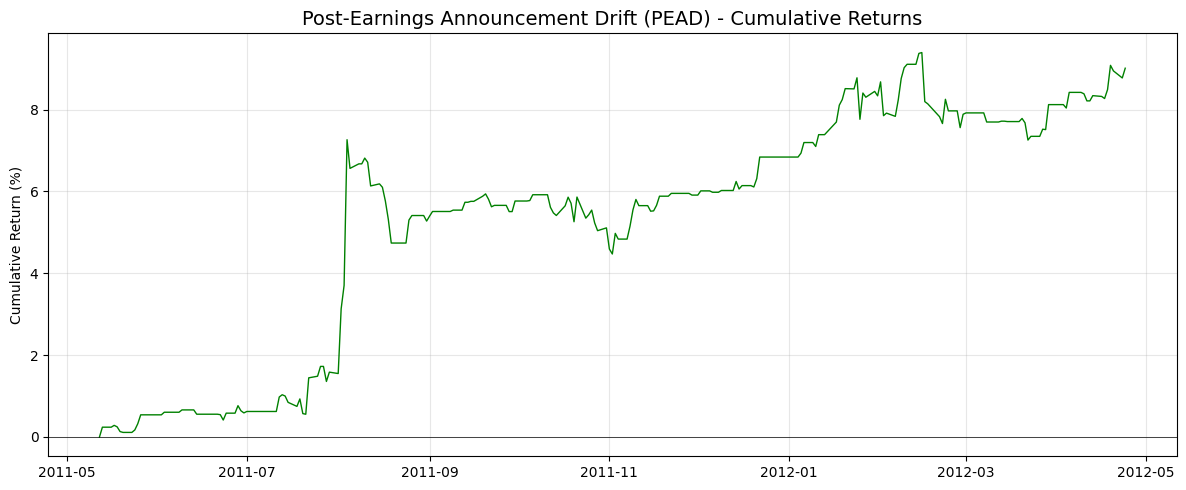

In [10]:
# === PEAD 차트 ===

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(cumret_pead.index, cumret_pead.values * 100, 'g-', linewidth=1)
ax.set_title('Post-Earnings Announcement Drift (PEAD) - Cumulative Returns', fontsize=14)
ax.set_ylabel('Cumulative Return (%)')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

---

## 7. 전략 종합 비교

| 전략 | APR | Sharpe | Max DD | 특성 |
|------|-----|--------|--------|------|
| Buy-on-Gap | 8.28% | 1.64 | -5.25% | 일중, 롱온리 |
| SPY Index Arb | 4.51% | 1.32 | -3.04% | 일간, 롱-숏 |
| Linear L/S (C2C) | 13.69% | 1.26 | -9.94% | 일간, 달러 중립 |
| Linear L/S (Intra) | 73.23% | 4.72 | -6.13% | 일중, 달러 중립 |
| PEAD | 9.49% | 1.75 | -2.61% | 일중, 이벤트 기반 |

---

## 8. 결론 및 권고사항

### 핵심 발견

1. **개별 주식 페어 트레이딩의 한계**: 기업 펀더멘털 변화로 공적분 관계가 무너질 위험이 높다
2. **ETF 기반 전략의 안정성**: ETF는 바스켓 경제 변화가 느려 공적분 관계가 더 안정적
3. **횡단면 전략의 강건성**: Khandani-Lo 모델은 매개변수 없이도 안정적 수익 달성
4. **일중 전략의 높은 성과**: 시가-종가 전략이 종가-종가보다 월등히 높은 수익률

### 트레이딩 권고

- 평균 회귀 전략에 **모멘텀 필터** 를 중첩하면 일관성 향상
- 횡단면 전략에서 **소형주 유니버스** 를 사용하면 더 높은 수익률 기대 가능
- 인덱스 차익거래는 **주기적 재훈련** 이 필수적

### 주의사항

- **생존자 편향**: 사용된 S&P 500 데이터에 생존자 편향 존재
- **거래비용**: 모든 백테스트에 거래비용 미포함. 특히 일중 전략은 거래비용 2배
- **시그널 노이즈**: 시가 기반 진입 시 사전개장 가격과 실제 시가의 차이
- **공매도 제약**: 숏 포지션의 Alternative Uptick Rule, NBBO 규모 제한
- **슬리피지**: 통합 가격 vs 기본 거래소 가격 차이로 인한 백테스트 과대평가 가능성